# Exploring STR/VNTR Mutation models

## Key parameters:
* mu: per-generation mutation rate
* beta: length constraint
* p: step size parameter (geometric distribution)
* S: selection coefficient. Most fit allele has relative fitness 1. Next most has 1-s, next most has 1-2s, etc.
* num_alleles: Size of transition matrix to build. Centered at "0" (most optimal allele in the center)

In [1]:
########## Function definitions and imports ##############

%pylab inline
import numpy as np
from scipy.stats import geom

# Geometric step size prob
def GetStepSizeProb(a1, a2, beta, p):
    step_size = (a2-a1)
    if abs(step_size)>10: return 0 # TODO limit?
    up_prob = max([0,0.5*(1-beta*p*a1)])
    down_prob = 1-up_prob
    if step_size>0: dir_prob = up_prob
    else: dir_prob = down_prob
    step_prob = geom.pmf(abs(step_size), p)
    return dir_prob*step_prob

### Main function to build transition matrix #####
# Fill in transition matrix for a set of mutation+selection params
def GetTransitionMatrix(num_alleles, mu, beta, p, S):
    MINVAL = 0.001 # avoid 0's
    # Initialize matrix (optimal=0)
    transition_matrix = np.zeros((NUM_ALLELES, NUM_ALLELES))

    # Fill in probability to transition from a1 to a2
    for i in range(num_alleles):
        for j in range(num_alleles):
            a1 = -1*int(num_alleles/2)+i
            a2 = -1*int(num_alleles/2)+j
            if a1==a2: transition_matrix[i,j] = 1-mu
            else:
                prob = GetStepSizeProb(a1, a2, beta, p)
                transition_matrix[i,j] = mu*prob
            w = max([MINVAL, 1-abs(a2)*S]) #np.exp(-1*abs(a2)*S) 
            transition_matrix[i,j] = w*transition_matrix[i,j]
        
    # Fix boundaries to avoid probability leakage
    transition_matrix[:,0] = 0
    transition_matrix[0,0] = 1
    transition_matrix[:,num_alleles-1] = 0
    transition_matrix[num_alleles-1,num_alleles-1] = 1

    # Rescale each row to sum to 1 (which should hopefully be mostly true anyway)
    for i in range(num_alleles):
        rowsum = np.sum(transition_matrix[i,:])
        transition_matrix[i,:] = transition_matrix[i,:]/rowsum

    return transition_matrix

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


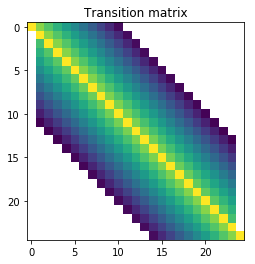

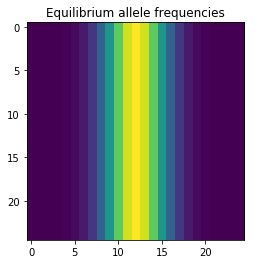

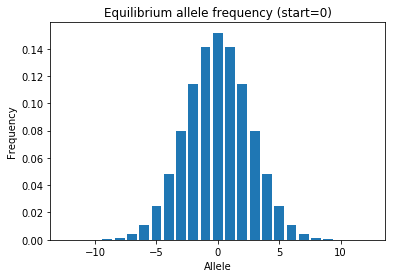

In [2]:
# Visualize an example

NUM_ALLELES = 25

PARAM_beta = 0.1
PARAM_mu = 10e-3
PARAM_p = 0.9
PARAM_S = 0

transition_matrix = GetTransitionMatrix(NUM_ALLELES, PARAM_mu, PARAM_beta, PARAM_p, PARAM_S)

# Visualize matrix after 1 gen
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(np.log10(transition_matrix))
ax.set_title("Transition matrix")

# Visualize matrix after N gen
# Each row i gives equilibrium allele freq given starting at allele i
# 0 is "optimal"
NUM_GEN = 1000000
eql_matrix = np.matrix(transition_matrix)**NUM_GEN
np.clip(eql_matrix, 1e-10, 1.0, out=eql_matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(eql_matrix)
ax.set_title("Equilibrium allele frequencies")

# Vis equilibrium allele freq distribution for starting at "optimal" (0)
afreqs = np.array(eql_matrix[int(NUM_ALLELES/2),:])[0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(list(range(-1*int(NUM_ALLELES/2), int(NUM_ALLELES/2)+1)), afreqs)
ax.set_title("Equilibrium allele frequency (start=0)")
ax.set_xlabel("Allele")
ax.set_ylabel("Frequency");

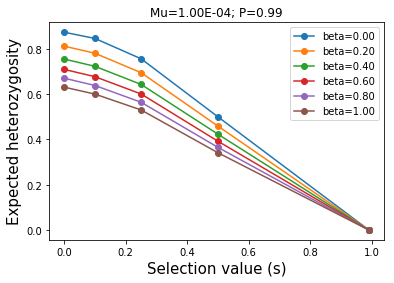

In [3]:
#### Look at expected heterozygosity as a function of S (fixing all other params) ####

# Set constant params
PARAM_mu = 10e-5
PARAM_p = 0.99
NUM_ALLELES = 25 # Number of alleles to consider in the matrix
NUM_GEN = 50000 # Number of generations to consider

svals = [0, 0.1, 0.25, 0.5, 0.99]
beta_vals = np.arange(0, 1.01, 0.2)

fig = plt.figure()
ax = fig.add_subplot(111)

for PARAM_beta in beta_vals:
    hetvals = []
    for PARAM_s in svals:
        transition_matrix = GetTransitionMatrix(NUM_ALLELES, PARAM_mu, PARAM_beta, PARAM_p, PARAM_s)
        eql_matrix = np.matrix(transition_matrix)**NUM_GEN
        np.clip(eql_matrix, 1e-10, 1.0, out=eql_matrix)
        afreqs = np.array(eql_matrix[int(NUM_ALLELES/2),:])[0] # assume 0 was starting allele at time 0
        het = 1-sum([item**2 for item in afreqs]) 
        hetvals.append(het)
    ax.plot(svals, hetvals, marker="o", label="beta=%.2f"%PARAM_beta)
ax.set_xlabel("Selection value (s)", size=15)
ax.set_ylabel("Expected heterozygosity", size=15);
ax.set_title("Mu=%.2E; P=%.2f"%(PARAM_mu, PARAM_p))
ax.legend()